In [5]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import os
import pickle

linewidth = 4
colors = plt.cm.Dark2.colors
plt.rcParams.update(
    {
        'font.size': 24,
        'text.usetex': True,
        'axes.linewidth': linewidth,
        'xtick.major.width': linewidth,
        'ytick.major.width': linewidth,
        'xtick.major.size': 2*linewidth,
        'ytick.major.size': 2*linewidth,
    }
)
#TODO Param changes
alpha = 0.2
xlim = (0, 200)
ylim = (0, None)
# ylim = (0, 150)
rolling_mean = 10
figsize = (12,6)

# Visualize regrets

Config: 
feature_dim :  2
num_arms :  100
num_seeds :  20
seed :  42
domain :  {'initialization': 'meshgrid', 'params': {'range': [[-5.0, 5.0], [-5.0, 5.0]]}, 'norm_ub': None}
num_iter :  200
utility_function :  ackley
utility_function_params :  {'param_initialization': 'normal', 'param_norm_ub': 1.0, 'utility_range': [-3.0, 3.0], 'bias': 0.0, 'poly_degree': 1}
activation_function :  sigmoid
estimator :  {'name': 'LGPUCB', 'delta': 0.1, 'lambda_': 0.25, 'nll_regularization_penalty': 1.0, 'beta': 1.0, 'rkhs_norm_ub': 1.0, 'kernel': 'rbf', 'kernel_params': {'variance': 1.0, 'length_scale': 1.0}, 'solver': {'name': 'LBFGS', 'args': {}}}
acquisition_functions :  ['max_min_lcb_no_candidates', 'RUCB', 'max_info_gain', 'Doubler_single_estimator', 'MultiSBM', 'IDS', 'Sparring']

Algorithm results paths
Result path:  max_min_lcb_no_candidates_gpo.pkl
Plotting cumulative regret for  duelling
Plotting cumulative regret for  weak
Plotting cumulative regret for  strong
Plotting cumulative regret fo

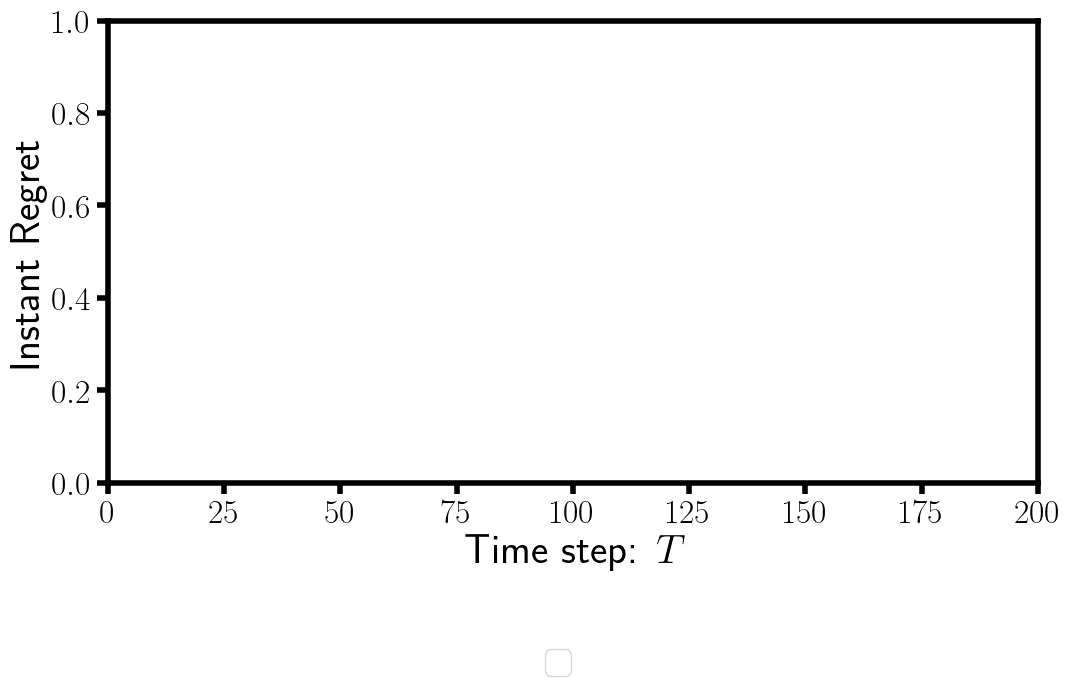

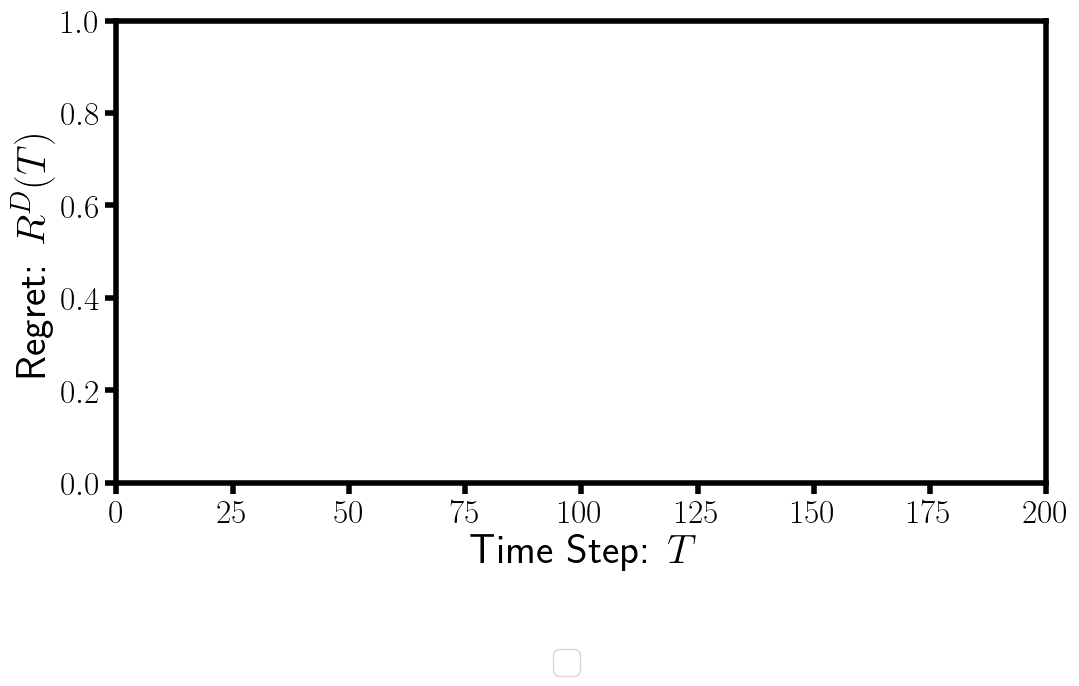

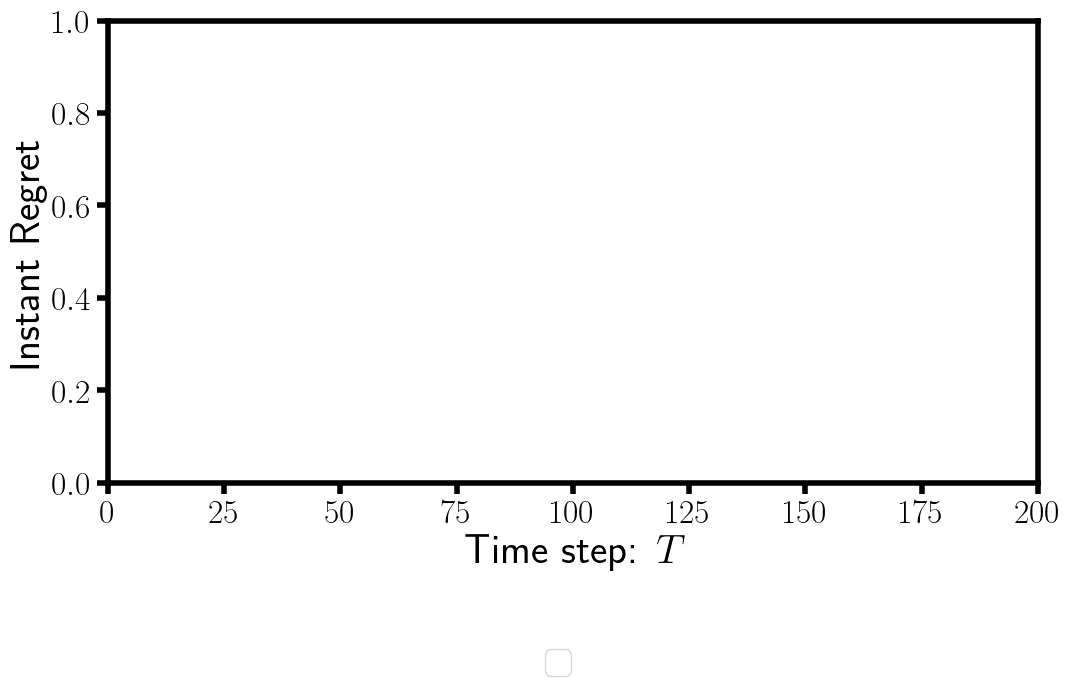

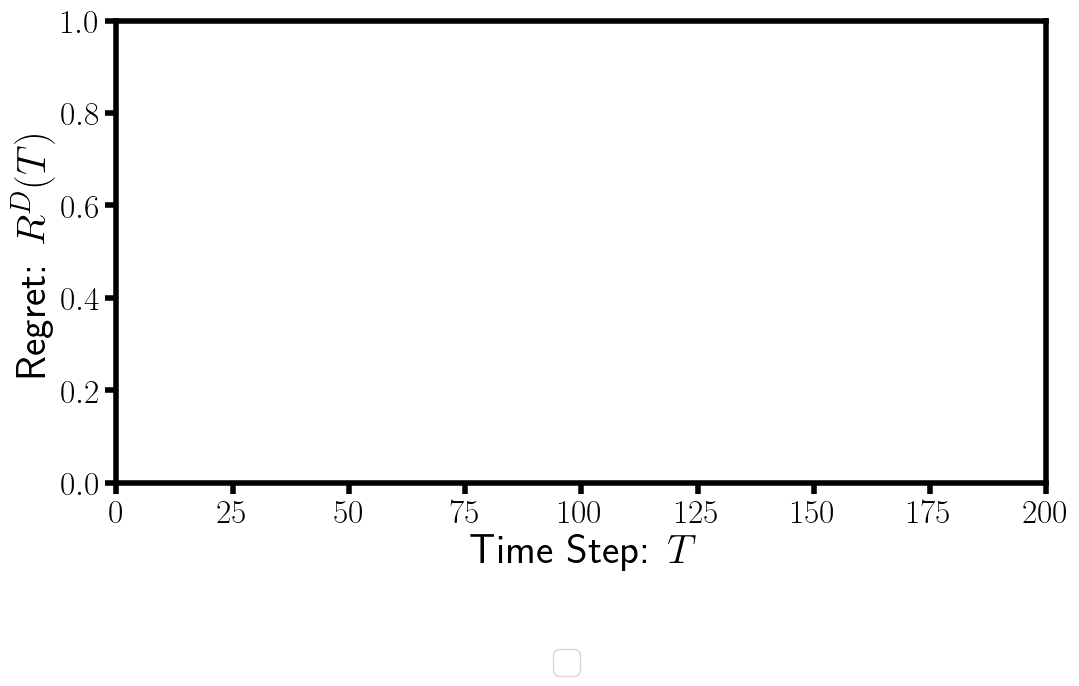

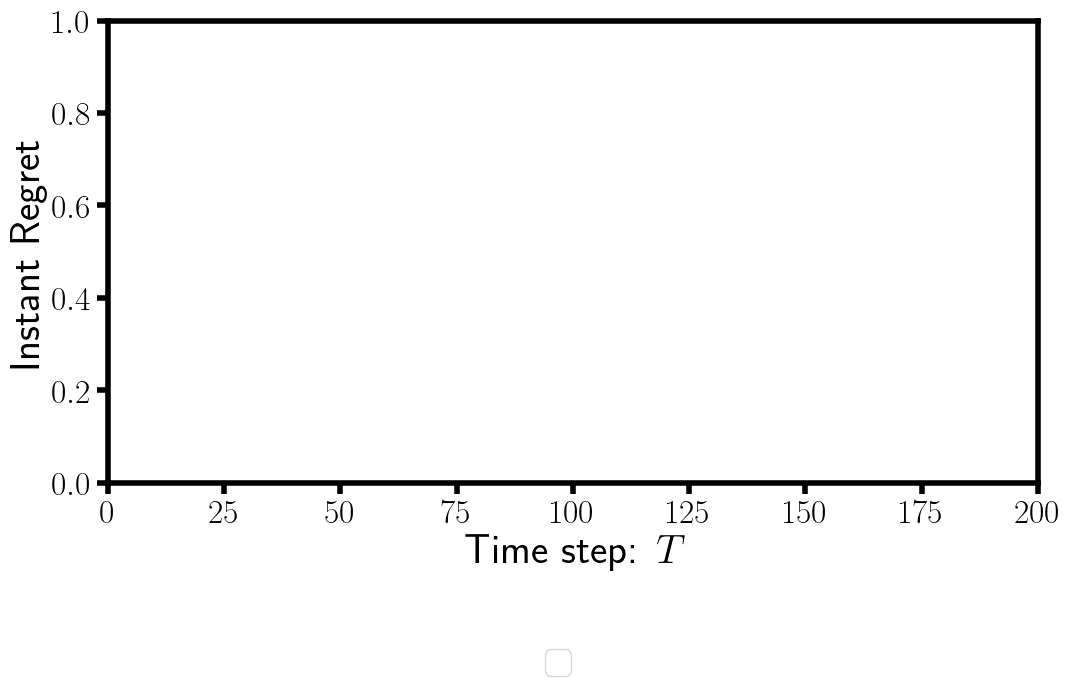

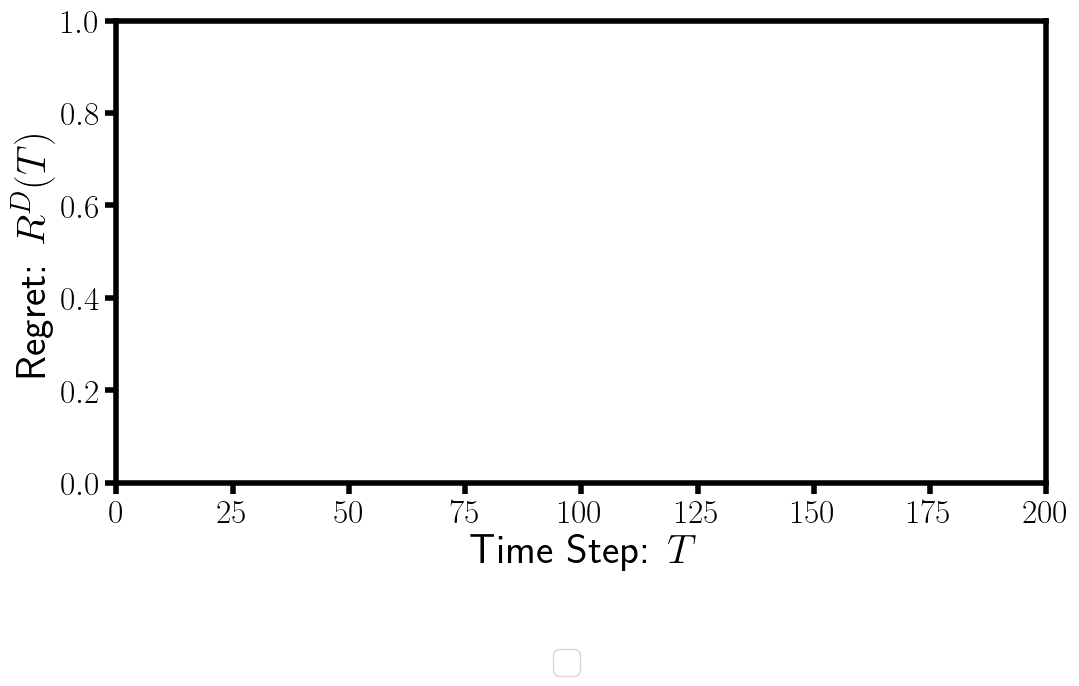

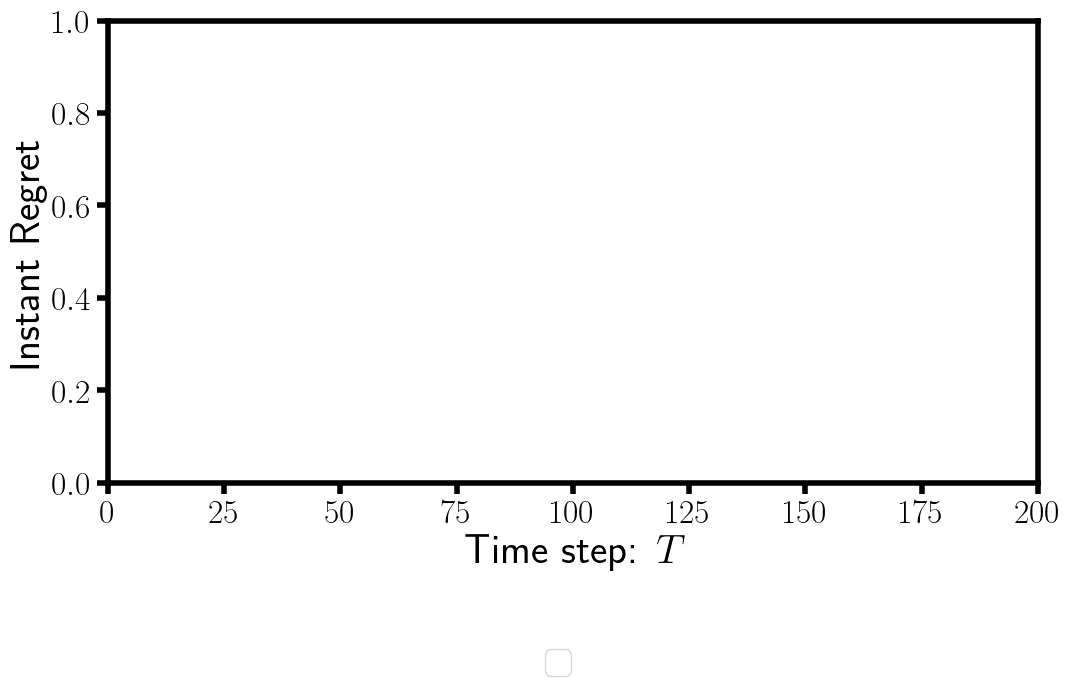

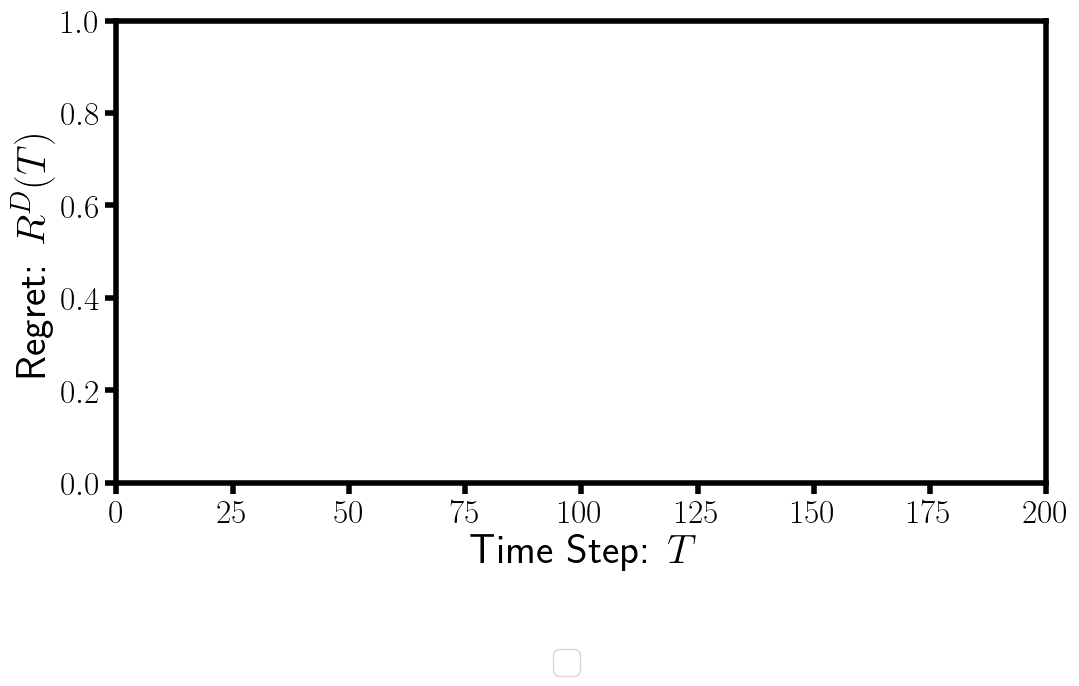

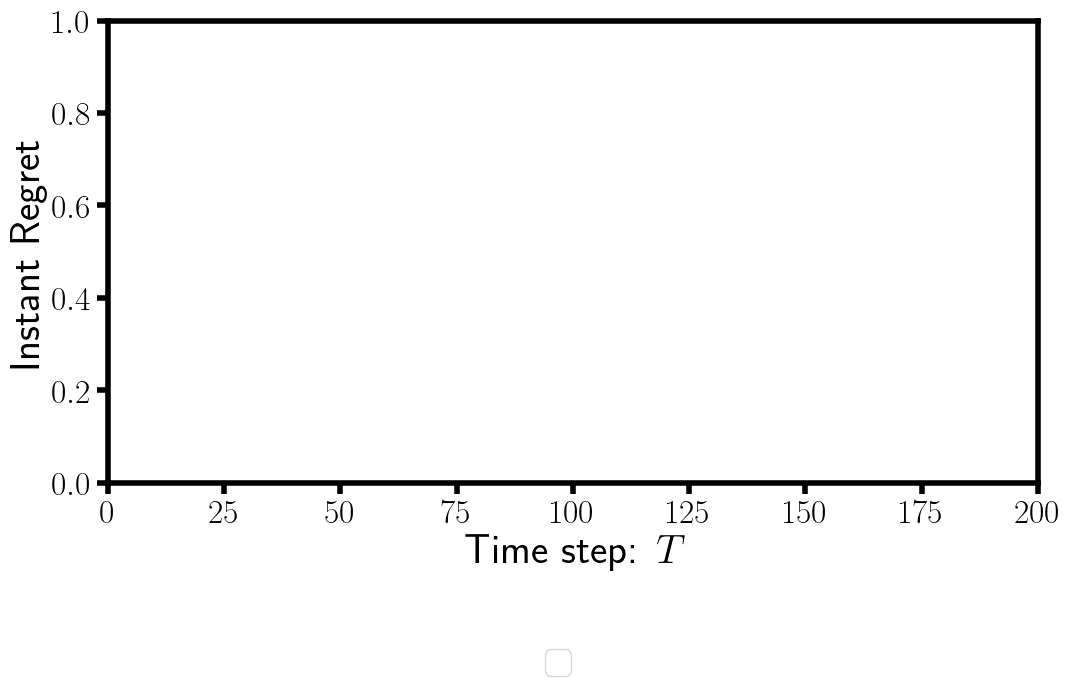

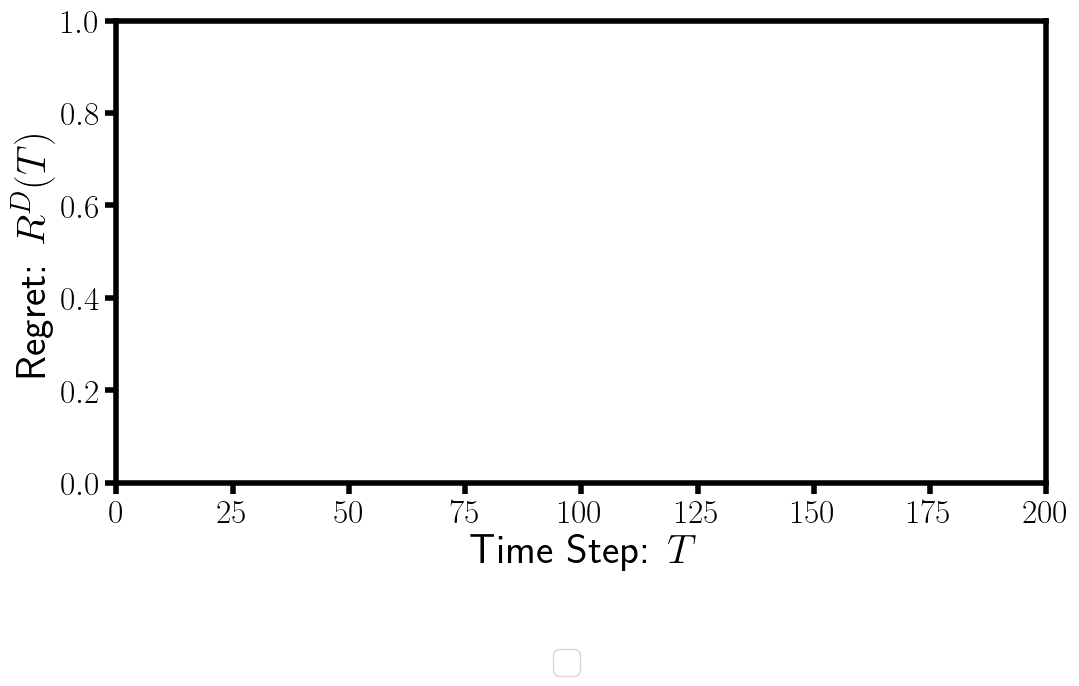

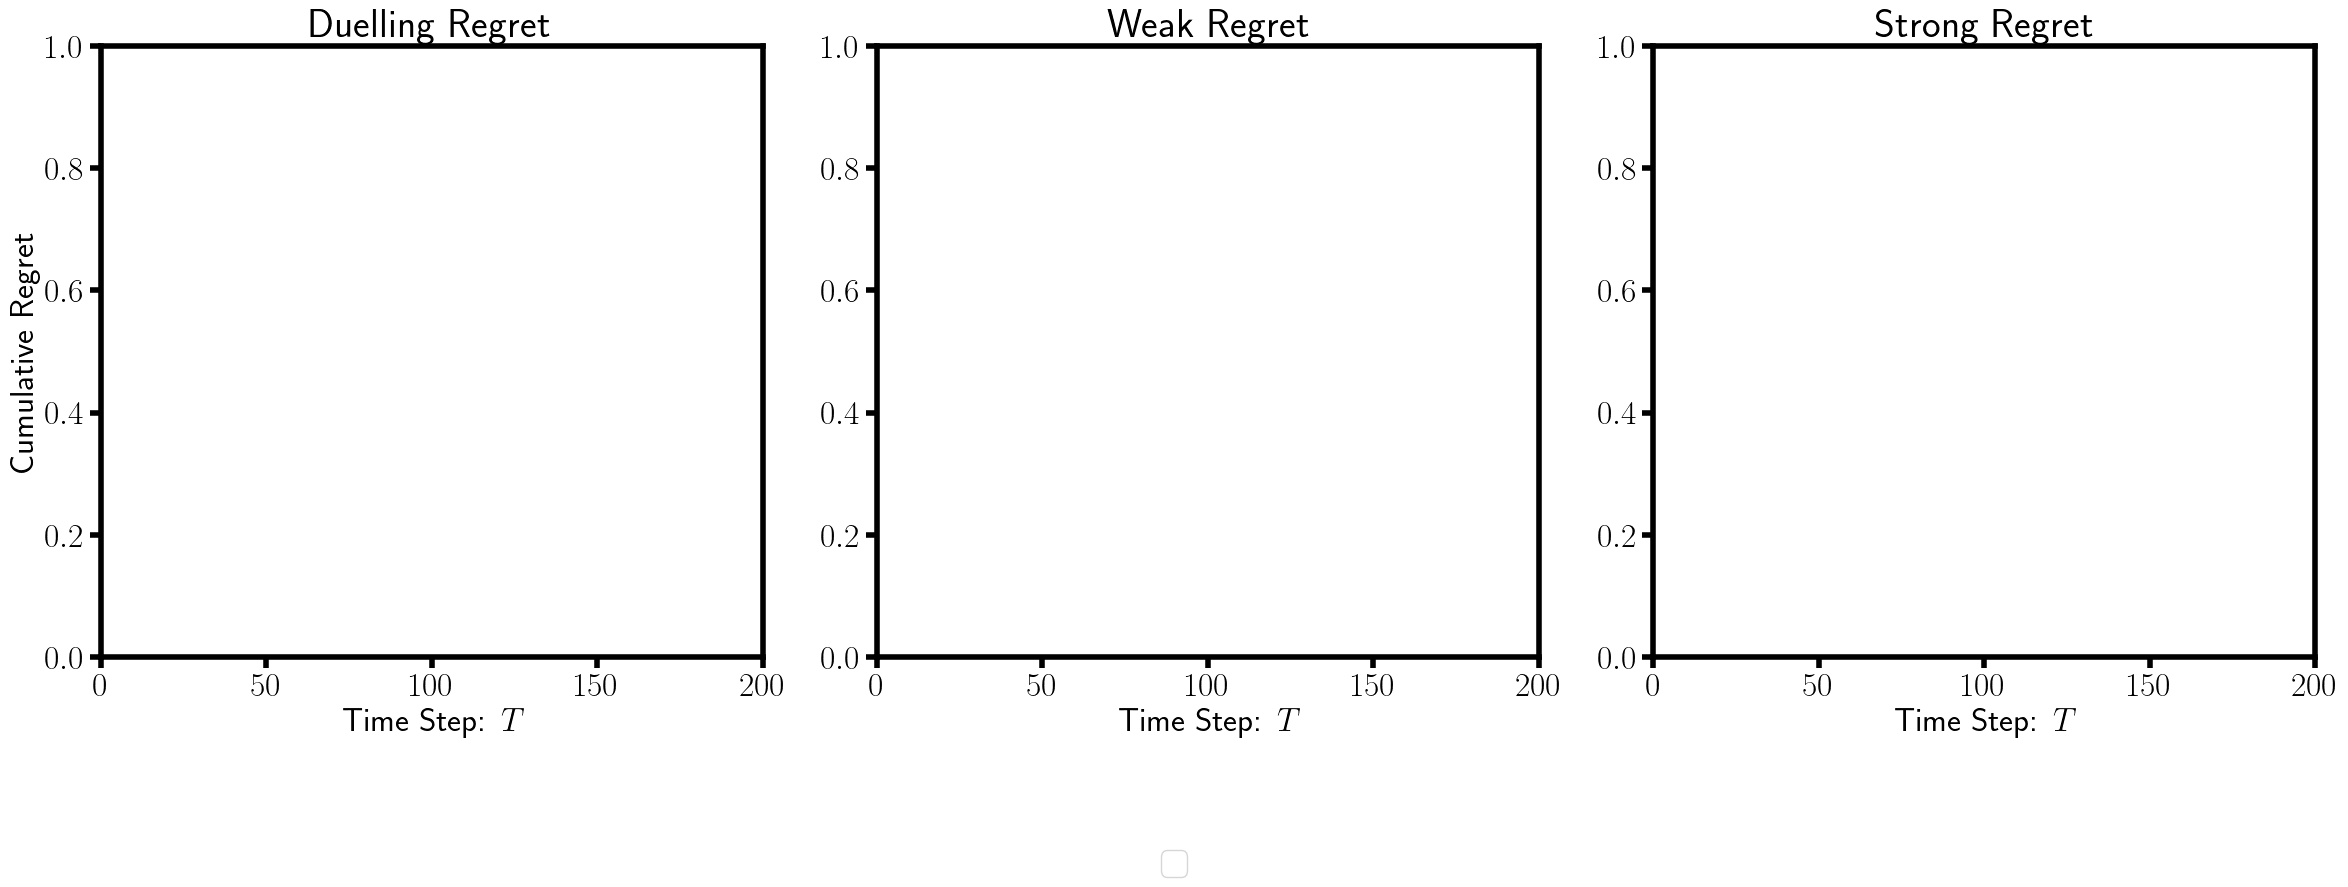

In [6]:
input_dir = "../data/preference_feedback/ackley"
save_figs = True
gpo = True

# Load the data
config = yaml.safe_load(open(input_dir + "/config.yaml", "r"))
print("Config: ")
for key, values in config.items():
    print(key, ": ", values)

print("\nAlgorithm results paths")
results_dir = {}
estimator_params_dir = {}
for result_file in os.listdir(input_dir):
    gpo_check = result_file.endswith("_gpo.pkl")
    gpo_check = gpo_check if gpo else not gpo_check
    if result_file.endswith(".pkl") and not result_file.endswith("estimator_params.pkl") and not result_file.endswith("grid_search_params.pkl") and gpo_check:
        print("Result path: ", result_file)
        algo_name = result_file.split(".")[0]
        with open(input_dir + "/" + result_file, "rb") as f:
            data = pickle.load(f)
        results_dir[algo_name] = data


algo_label = {
    "max_info_gain": r"$\textsc{MaxInP}$",
    "max_min_lcb": r"$\textsc{MaxMinLCB} (Ours)$",
    "MultiSBM": r"$\textsc{MultiSBM}$",
    "IDS": r"$\textsc{IDS}$",
    "Doubler_single_estimator": r"$\textsc{Doubler}$",
    "max_min_lcb_no_candidates": r"$\textsc{MaxMinLCB} (Ours)$",
    "RUCB": r"$\textsc{RUCB}$",
    "doubleTS": r"$\textsc{DoubleTS}$",
}
algo_color = {
    "max_min_lcb_no_candidates": colors[0],
    "max_info_gain": colors[1],
    "Doubler_single_estimator": colors[2],
    "RUCB": colors[3],
    "MultiSBM": colors[5],
    "IDS": colors[6],
    "doubleTS": colors[7],
}
algo_linestyle = {
    "max_info_gain": (0, (3, 3, 1, 3)),
    "MultiSBM": (0, (3, 1, 3, 3)),  # "loosely dashed",
    "IDS": (0, (3, 2, 1, 1, 1, 2)),  # "dashdotdotted",
    "Doubler_single_estimator": "dashed",  # "dashdotted",
    "max_min_lcb_no_candidates": "solid",
    "RUCB": "dotted",
    "doubleTS": (0, (3, 3, 1, 3)),
}
algo_order = [
    "max_min_lcb_no_candidates",
    "max_info_gain",
    "Doubler_single_estimator",
    "RUCB",
    "MultiSBM",
    "IDS",
    "doubleTS",
]

# Plot average cumulative regret for the different algorithms
fig_combined, axes_combined = plt.subplots(1, 3, figsize=(24, 8))
for i, regret_type in enumerate(["duelling", "weak", "strong", "first", "second"]):
    print("Plotting cumulative regret for ", regret_type)
    fig1, ax1 = plt.subplots(figsize=figsize)
    fig2, ax2 = plt.subplots(figsize=figsize)
    for algo_name in algo_order:
        if algo_name not in results_dir:
            continue
        outputs = results_dir[algo_name]
        regret = outputs["regrets"]
        regret[jnp.isnan(regret)] = 0
        if regret_type == "duelling":
            regret = jnp.mean(regret, axis=-1)
        elif regret_type == "weak":
            regret = jnp.min(regret, axis=-1)
        elif regret_type == "strong":
            regret = jnp.max(regret, axis=-1)
        elif regret_type == "first":
            regret = regret[..., 0]
        elif regret_type == "second":
            regret = regret[..., 1]
        else:
            raise ValueError("Invalid regret type")
        print(regret)
        cumulative_regret = jnp.cumsum(regret, axis=-1)
        # Plot instant regret
        smoothed_regret = (cumulative_regret[..., rolling_mean:] - cumulative_regret[..., :-rolling_mean]) / rolling_mean
        mean_regret = jnp.nanmean(smoothed_regret, axis=0)
        std_regret = jnp.nanstd(smoothed_regret, axis=0)/jnp.sqrt(smoothed_regret.shape[0])
        ax1.plot(
            mean_regret,
            label=algo_label[algo_name],
            color=algo_color[algo_name],
            linestyle=algo_linestyle[algo_name],
            linewidth=linewidth,
        )
        ax1.fill_between(
            jnp.arange(len(mean_regret)),
            mean_regret - std_regret,
            mean_regret + std_regret,
            alpha=alpha,
            color=algo_color[algo_name],
        )

        # Plot cumulative regret
        mean_regret = jnp.nanmean(cumulative_regret, axis=0)
        std_regret = jnp.nanstd(cumulative_regret, axis=0)/jnp.sqrt(cumulative_regret.shape[0])
        ax2.plot(
            mean_regret,
            label=algo_label[algo_name],
            color=algo_color[algo_name],
            linestyle=algo_linestyle[algo_name],
            linewidth=1.5*linewidth,
        )
        ax2.fill_between(
            jnp.arange(len(mean_regret)),
            mean_regret - std_regret,
            mean_regret + std_regret,
            alpha=alpha,
            color=algo_color[algo_name],
        )
        if regret_type in ["weak", "strong", "duelling"]:
            axes_combined[i].plot(
                mean_regret,
                label=algo_label[algo_name],
                color=algo_color[algo_name],
                linestyle=algo_linestyle[algo_name],
                linewidth=1.5*linewidth,
            )
            axes_combined[i].fill_between(
                jnp.arange(len(mean_regret)),
                mean_regret - std_regret,
                mean_regret + std_regret,
                alpha=alpha,
                color=algo_color[algo_name],
            )

    lines, legends = ax1.get_legend_handles_labels()
    lgd = fig1.legend(lines, legends, loc="lower center", bbox_to_anchor=(0.5, -0.24), ncol=3)
    ax1.set_xlabel(r"Time step: $T$", fontsize=30)
    ax1.set_ylabel(r"Instant Regret", fontsize=30)
    ax1.set_xlim(xlim)

    lines, legends = ax2.get_legend_handles_labels()
    lgd = fig2.legend(lines, legends, loc="lower center", bbox_to_anchor=(0.5, -0.24), ncol=3)
    ax2.set_xlabel(r"Time Step: $T$", fontsize=30)
    ax2.set_ylabel(r"Regret: $R^D(T)$", fontsize=30)
    ax2.set_xlim(xlim)
    ax2.set_ylim(ylim)

    plt.figure(fig1.number)
    plt.figure(fig2.number)
    if save_figs:
        file_end = "_gpo" if gpo else ""
        plt.savefig(os.path.join(input_dir, f"instant_{regret_type}_regret{file_end}.pdf"), bbox_inches="tight")
        plt.savefig(os.path.join(input_dir, f"cumulative_{regret_type}_regret{file_end}.pdf"), bbox_inches="tight")

plt.figure(fig_combined.number)
lines, legends = axes_combined[0].get_legend_handles_labels()
lgd = fig_combined.legend(lines, legends, loc="lower center", bbox_to_anchor=(0.5, -0.15), ncol=6)
axes_combined[0].set_ylabel("Cumulative Regret")
for i, regret_type in enumerate(["duelling", "weak", "strong"]):
    axes_combined[i].set_xlabel(r"Time Step: $T$")
    axes_combined[i].set_title(rf"{regret_type.capitalize()} Regret")
    axes_combined[i].set_xlim(xlim)
    axes_combined[i].set_ylim(ylim)
# tight layout
plt.tight_layout()
plt.savefig(os.path.join(input_dir, "cumulative_combined_regret.pdf"), bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

# Regret Comparison Table

In [7]:
T = 2000
algo_order = [
    "max_min_lcb_no_candidates",
    "Doubler_single_estimator",
    "MultiSBM",
    "max_info_gain",
    "RUCB",
    "IDS",
    "doubleTS",
]

input_paths = {
    "ackley": "../data/preference_feedback/ackley",
    "branin": "../data/preference_feedback/branin",
    "eggholder": "../data/preference_feedback/eggholder",
    "hoelder": "../data/preference_feedback/hoelder",
    "matyas": "../data/preference_feedback/matyas",
    "michalewicz": "../data/preference_feedback/michalewicz",
    "rosenbrock": "../data/preference_feedback/rosenbrock",
    "yelp": "../data/preference_feedback/yelp",
}

dataframes = {}
regret = {}
for name, input_dir in input_paths.items():
    for algo_name in algo_order:
        try:
            with open(input_dir + f"/{algo_name}.pkl", "rb") as f:
                data = pickle.load(f)
            avg_regret = jnp.mean(data["regrets"], axis=-1)  # Duelling regret, Shape: (num_seeds, T)
            avg_cumulative_regret = jnp.cumsum(avg_regret, axis=-1)[:,-1]  # Shape: (num_seeds,)
            mean = jnp.mean(avg_cumulative_regret)
            std_err = jnp.std(avg_cumulative_regret)/jnp.sqrt(avg_cumulative_regret.shape[0])
            regret[(name, algo_name)] = (mean, std_err)
        except FileNotFoundError:
            print(f"File not found: {input_dir}/{algo_name}.pkl")
            regret[(name, algo_name)] = (jnp.nan, jnp.nan)
df = pd.DataFrame(regret).T
df.columns = ["Mean", "StdErr"]
print("Regret Table")
display(df["Mean"].unstack()[algo_order])
print("Standard Error Table")
display(df["StdErr"].unstack()[algo_order])

File not found: ../data/preference_feedback/ackley/Doubler_single_estimator.pkl
File not found: ../data/preference_feedback/ackley/MultiSBM.pkl
File not found: ../data/preference_feedback/ackley/max_info_gain.pkl
File not found: ../data/preference_feedback/ackley/RUCB.pkl
File not found: ../data/preference_feedback/ackley/IDS.pkl
File not found: ../data/preference_feedback/ackley/doubleTS.pkl
File not found: ../data/preference_feedback/branin/max_min_lcb_no_candidates.pkl
File not found: ../data/preference_feedback/branin/Doubler_single_estimator.pkl
File not found: ../data/preference_feedback/branin/MultiSBM.pkl
File not found: ../data/preference_feedback/branin/max_info_gain.pkl
File not found: ../data/preference_feedback/branin/RUCB.pkl
File not found: ../data/preference_feedback/branin/IDS.pkl
File not found: ../data/preference_feedback/branin/doubleTS.pkl
File not found: ../data/preference_feedback/eggholder/max_min_lcb_no_candidates.pkl
File not found: ../data/preference_feedback

,max_min_lcb_no_candidates,Doubler_single_estimator,MultiSBM,max_info_gain,RUCB,IDS,doubleTS
ackley,-47.866497,NaN,NaN,NaN,NaN,NaN,NaN
branin,NaN,NaN,NaN,NaN,NaN,NaN,NaN
eggholder,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hoelder,NaN,NaN,NaN,NaN,NaN,NaN,NaN
matyas,NaN,NaN,NaN,NaN,NaN,NaN,NaN
michalewicz,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rosenbrock,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yelp,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Standard Error Table


,max_min_lcb_no_candidates,Doubler_single_estimator,MultiSBM,max_info_gain,RUCB,IDS,doubleTS
ackley,2.3113906,NaN,NaN,NaN,NaN,NaN,NaN
branin,NaN,NaN,NaN,NaN,NaN,NaN,NaN
eggholder,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hoelder,NaN,NaN,NaN,NaN,NaN,NaN,NaN
matyas,NaN,NaN,NaN,NaN,NaN,NaN,NaN
michalewicz,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rosenbrock,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yelp,NaN,NaN,NaN,NaN,NaN,NaN,NaN
